# Voronoï et régression logistique

Le notebook étudie la pertinence d'un modèle de régression logistique dans certaines configurations. Il regarde aussi le diagramme de Voronoï associé à une régression logistique à trois classes. Il donne quelques intuitions sur les modèles que la régression logistique peut résoudre.

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

In [2]:
%matplotlib inline

## Régression logistique

In [3]:
from sklearn.datasets import load_iris
data = load_iris()
X, y = data.data[:, :2], data.target

In [4]:
from sklearn.linear_model import LogisticRegression
clr = LogisticRegression()
clr.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [5]:
clr.coef_

array([[-2.49579289,  4.01011301],
       [ 0.49709451, -1.63380222],
       [ 1.15921404, -1.77736568]])

In [6]:
clr.intercept_

array([ 0.81713932,  1.22543562, -2.22516119])

In [7]:
import numpy
x = numpy.array([[1, 2]])
clr.decision_function(x)

array([[ 6.34157245, -1.54507432, -4.6206785 ]])

In [8]:
A = clr.coef_
B = clr.intercept_

On vérifie que la fonction de décision correspond à la formule suivant.

In [9]:
(A@x.T).T.ravel() + B

array([ 6.34157245, -1.54507432, -4.6206785 ])

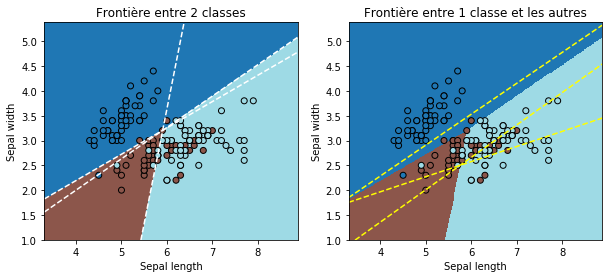

In [10]:
import matplotlib.pyplot as plt

def draw_border(clr, X, y, fct=None, incx=1, incy=1, figsize=None, border=True, ax=None):
    
    # voir https://sashat.me/2017/01/11/list-of-20-simple-distinct-colors/
    # https://matplotlib.org/examples/color/colormaps_reference.html
    _unused_ = ["Red", "Green", "Yellow", "Blue", "Orange", "Purple", "Cyan",
              "Magenta", "Lime", "Pink", "Teal", "Lavender", "Brown", "Beige",
              "Maroon", "Mint", "Olive", "Coral", "Navy", "Grey", "White", "Black"]

    h = .02  # step size in the mesh
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    x_min, x_max = X[:, 0].min() - incx, X[:, 0].max() + incx
    y_min, y_max = X[:, 1].min() - incy, X[:, 1].max() + incy
    xx, yy = numpy.meshgrid(numpy.arange(x_min, x_max, h), numpy.arange(y_min, y_max, h))
    if fct is None:
        Z = clr.predict(numpy.c_[xx.ravel(), yy.ravel()])
    else:
        Z = fct(clr, numpy.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    cmap = plt.cm.tab20
    Z = Z.reshape(xx.shape)
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=figsize or (4, 3))
    ax.pcolormesh(xx, yy, Z, cmap=cmap)

    # Plot also the training points
    ax.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', cmap=cmap)
    ax.set_xlabel('Sepal length')
    ax.set_ylabel('Sepal width')

    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    
    # Draw lines
    x1, x2 = xx.min(), xx.max()
    cl = 0
    if border:
        for i in range(0, clr.coef_.shape[0]):
            for j in range(i+1, clr.coef_.shape[0]):
                delta = clr.coef_[i] - clr.coef_[j]
                db = clr.intercept_[i] - clr.intercept_[j]
                y1 = (-db - delta[0] * x1) / delta[1]
                y2 = (-db - delta[0] * x2) / delta[1]
                ax.plot([x1, x2], [y1, y2], '--', color="white")
                cl += 1
    else:
        for i in range(0, clr.coef_.shape[0]):
            delta = clr.coef_[i]
            db = clr.intercept_[i]
            y1 = (-db - delta[0] * x1) / delta[1]
            y2 = (-db - delta[0] * x2) / delta[1]
            ax.plot([x1, x2], [y1, y2], '--', color="yellow")
            cl += 1
    
    return ax

fig, ax = plt.subplots(1, 2, figsize=(10,4))
draw_border(clr, X, y, ax=ax[0])
draw_border(clr, X, y, border=False, ax=ax[1])
ax[0].set_title("Frontière entre 2 classes")
ax[1].set_title("Frontière entre 1 classe et les autres");

## Quelques diagramme de Voronoï

In [11]:
points = numpy.array([[1, 2], [3, 4], [4, 1]])

In [12]:
from scipy.spatial import Voronoi, voronoi_plot_2d
vor = Voronoi(points)

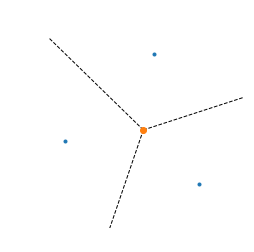

In [13]:
fig, ax = plt.subplots(figsize=(4,4))
ax.ishold = lambda: True  # bug between scipy and matplotlib 3.0
voronoi_plot_2d(vor, ax=ax)
ax.set_xlim([0, 5])
ax.set_ylim([0, 5])
ax.axis('off');

In [14]:
vor.point_region

array([3, 1, 2], dtype=int64)

In [15]:
vor.vertices

array([[2.75, 2.25]])

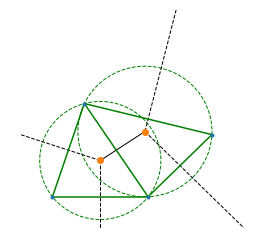

In [16]:
from matplotlib.patches import Circle
from matplotlib.collections import PatchCollection
points = numpy.array([[1, 1], [2, 4], [4, 1], [6,3]])
vor = Voronoi(points)
fig, ax = plt.subplots(figsize=(4,4))
cs = []
for i in range(vor.vertices.shape[0]):
    v = vor.vertices[i, :]
    d = (v - points[2, :])
    r = (d.dot(d) ** 0.5)
    circle = Circle((v[0], v[1]), r, fill=False, ls='--', edgecolor='g', visible=True)
    ax.add_artist(circle)
for i in range(points.shape[0]):
    for j in range(i+1, points.shape[0]):
        if i == 0 and j == 3:
            continue
        ax.plot(points[[i, j], 0], points[[i, j], 1], "g-")
ax.ishold = lambda: True  # bug between scipy and matplotlib 3.0
voronoi_plot_2d(vor, ax=ax)
ax.set_xlim([0, 7])
ax.set_ylim([0, 7])
ax.axis('off');

In [17]:
import math
n = 5
a = math.pi * 2 / 3
points = []
for i in range(n):
    for j in range(n):
        points.append([i + j * math.cos(a), j * math.sin(a)])
points = numpy.array(points)

In [18]:
vor = Voronoi(points)

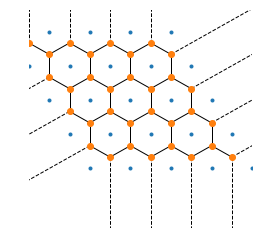

In [19]:
fig, ax = plt.subplots(figsize=(4,4))
ax.ishold = lambda: True  # bug between scipy and matplotlib 3.0
voronoi_plot_2d(vor, ax=ax)
ax.set_xlim([-1.5, 4])
ax.set_ylim([-1.5, 4])
ax.axis('off');

## Un diagramme de Voronoï proche

On applique la formule définie par [Régression logistique, diagramme de Voronoï, k-Means](http://www.xavierdupre.fr/app/mlstatpy/helpsphinx/c_ml/lr_voronoi.html) et on résoud le système linéaire défini par :

$$\begin{array}{ll}
&\left\{\begin{array}{l}\left<L_i - L_j, P_i \right> + B_i - B_j = - \left\{ \left<L_i - L_j, P_j \right> + B_i - B_j \right \} \\ P_i-  P_j - \left<P_i - P_j, \frac{L_i-L_j}{\Vert L_i-L_j\Vert} \right> \frac{L_i-L_j}{\Vert L_i-L_j\Vert }=0 \end{array} \right.
\\
\Longleftrightarrow & \left\{\begin{array}{l}\left<L_i - L_j, P_i + P_j\right> + 2 (B_i - B_j) = 0 \\ P_i-  P_j - \left<P_i - P_j, \frac{L_i-L_j}{\Vert L_i-L_j \Vert} \right> \frac{L_i-L_j}{\Vert L_i-L_j\Vert}=0 \end{array} \right.
\\
\Longrightarrow & \left\{\begin{array}{l} \left<L_i - L_j, P_i + P_j \right> + 2 (B_i - B_j) = 0 \\ \left<P_i-  P_j, u \right> - \left<P_i - P_j, \frac{L_i-L_j}{\Vert L_i-L_j\Vert} \right> \left<\frac{L_i-L_j}{\Vert L_i-L_j\Vert},u \right>=0 \end{array} \right.
\end{array} $$ 
    
Où $u$ est un vecteur unité quelconque. On cherche à résoudre sous la forme d'un système linéaire $LP=B$ où le vecteur $P$ est l'ensemble des coordonnées de tous les points cherchés. D'après la page cité ci-dessus, dans le cas d'un diagramme à trois classes, ce système a une infinité de solutions.

In [20]:
import numpy
matL = []
matB = []
L = clr.coef_
B = clr.intercept_
for i in range(0, L.shape[0]):
    for j in range(i + 1, L.shape[0]):
        li = L[i, :]
        lj = L[j, :]
        c = (li - lj)
        nc = (c.T @ c) ** 0.5
        
        # condition 1
        mat = numpy.zeros((L.shape))
        mat[i,:] = c
        mat[j,:] = c
        d = -2*(B[i] - B[j])
        matB.append(d)
        matL.append(mat.ravel())

        # condition 2 - cache plusieurs équations
        # on ne prend que la première coordonnée
        c /= nc
        c2 = c * c[0]
        mat = numpy.zeros((L.shape))        
        mat[i,:] = -c2
        mat[j,:] = c2
        
        mat[i,0] += 1
        mat[j,0] -= 1
        matB.append(0)
        matL.append(mat.ravel())

matL = numpy.array(matL)
matB = numpy.array(matB)
matL.shape, matB.shape, numpy.linalg.det(matL)

((6, 6), (6,), 2.0281820935727704e-16)

In [21]:
import pandas
pandas.DataFrame(matL)

0         1         2         3         4         5
0 -2.992887  5.643915 -2.992887  5.643915  0.000000  0.000000
1  0.780516  0.413897 -0.780516 -0.413897  0.000000  0.000000
2 -3.655007  5.787479  0.000000  0.000000 -3.655007  5.787479
3  0.714879  0.451472  0.000000  0.000000 -0.714879 -0.451472
4  0.000000  0.000000 -0.662120  0.143563 -0.662120  0.143563
5  0.000000  0.000000  0.044902  0.207088 -0.044902 -0.207088

Le déterminant est très faible suggérant que la matrice est non inversible et on sait qu'elle l'est dans ce cas. On remplace la dernière équation en forçant la coordonnée d'un point.

In [22]:
matL[-1,:] = 0
matL[-1,0] = 1
matB[-1] = 3
numpy.linalg.det(matL)

42.07770646874508

On vérifie que le système linéaire est celui attendu.

In [23]:
import pandas
df = pandas.DataFrame(matL)
df['B'] = matB
df

0         1         2         3         4         5         B
0 -2.992887  5.643915 -2.992887  5.643915  0.000000  0.000000  0.816593
1  0.780516  0.413897 -0.780516 -0.413897  0.000000  0.000000  0.000000
2 -3.655007  5.787479  0.000000  0.000000 -3.655007  5.787479 -6.084601
3  0.714879  0.451472  0.000000  0.000000 -0.714879 -0.451472  0.000000
4  0.000000  0.000000 -0.662120  0.143563 -0.662120  0.143563 -6.901194
5  1.000000  0.000000  0.000000  0.000000  0.000000  0.000000  3.000000

In [24]:
from numpy.linalg import inv
points = (inv(matL) @ matB).reshape((3,2))
points

array([[3.        , 4.12377262],
       [5.03684606, 0.2827372 ],
       [5.48745959, 0.18503334]])

In [25]:
x = points[0, :]
c1 = (L@x.T).T.ravel() + B
x = points[1, :]
c2 = (L@x.T).T.ravel() + B
x = points[2, :]
c3 = (L@x.T).T.ravel() + B
numpy.vstack([c1,c2,c3])

array([[  9.86655487,  -4.02070972,  -6.07697098],
       [-10.61997713,   3.26728747,   3.1110941 ],
       [-12.13641872,   3.65091377,   3.80710713]])

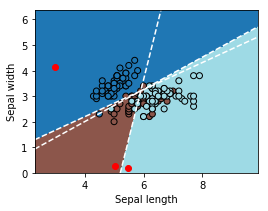

In [26]:
ax = draw_border(clr, X, y, incx=2, incy=2)
ax.plot(points[:, 0], points[:, 1], 'ro');

## Régression logistique dans un quadrillage

On s'intéresse un problème de régression logistique où le problème est très facile mais pas forcément évident du point de vue d'une régression logistique.

In [27]:
Xs = []
Ys = []
n = 20
for i in range(0, 4):
    for j in range(0, 3):
        x1 = numpy.random.rand(n) + i*1.1
        x2 = numpy.random.rand(n) + j*1.1
        Xs.append(numpy.vstack([x1,x2]).T)        
        Ys.extend([i*3+j] * n)
X = numpy.vstack(Xs)
Y = numpy.array(Ys)
X.shape, Y.shape

((240, 2), (240,))

In [28]:
set(Y)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}

On vérifie que le nuage de points est tel qu'indiqué.

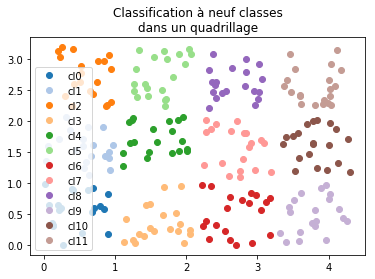

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))
for i in range(0, 12):
    ax.plot(X[Y==i,0], X[Y==i,1], 'o', label="cl%d"%i, color=plt.cm.tab20.colors[i])
ax.legend()
ax.set_title("Classification à neuf classes\ndans un quadrillage");

In [30]:
from sklearn.linear_model import LogisticRegression
clr = LogisticRegression()
clr.fit(X, Y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

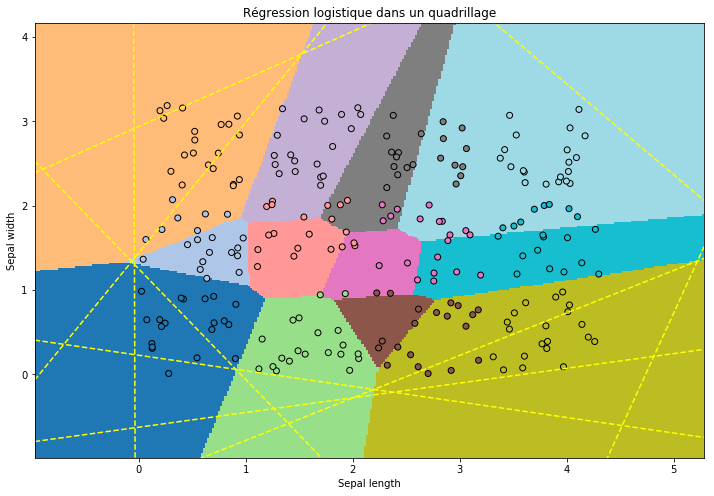

In [31]:
ax = draw_border(clr, X, Y, incx=1, incy=1, figsize=(12,8), border=False)
ax.set_title("Régression logistique dans un quadrillage");

In [32]:
clr.score(X, Y)

0.6958333333333333

On copie les features en les mettant au carré. Le problème est toujours aussi simple mais la régression logistique a plus de variables non corrélées sur lesquelles s'appuyer.

In [33]:
def create_feat(X):
    X2 = X.copy()
    X2[:, 0] = X2[:, 0] * X2[:, 0]
    X2[:, 1] = X2[:, 1] * X2[:, 1]
    XX2 = numpy.hstack([X, X2])
    return XX2

clr2 = LogisticRegression()
clr2.fit(create_feat(X), Y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

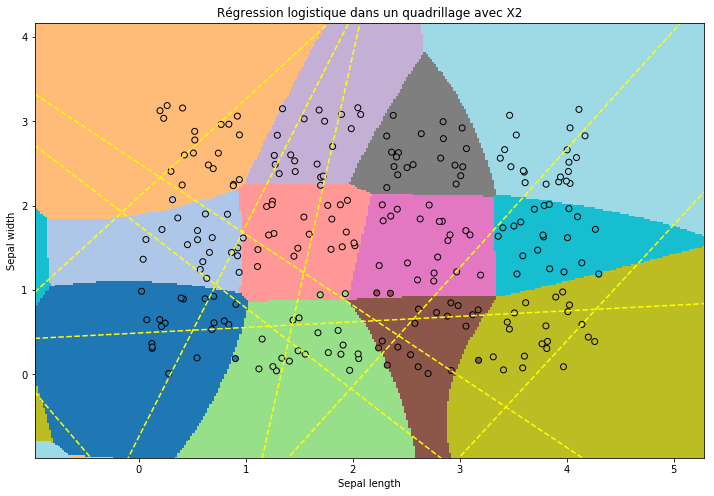

In [34]:
def fct_predict(clr, X):
    return clr.predict(create_feat(X))

ax = draw_border(clr2, X, Y, fct=fct_predict, incx=1, incy=1, figsize=(12,8), border=False)
ax.set_title("Régression logistique dans un quadrillage avec X2");

In [35]:
clr2.score(create_feat(X), Y)

0.9583333333333334

Du fait que ce problème de classification est équivalent à un diagramme de Voronoï, il a été construit comme tel, le fait que la régression logistique semble être provenir d'un problème de convergence numérique plutôt que du modèle théorique. Pour vérfier on joue avec les paramètres d'apprentissage. Tout d'abord, l'algorithme de descente de gradient.

In [36]:
clr_t = LogisticRegression(solver='lbfgs')
clr_t.fit(X, Y)
clr_t.score(X, Y)

0.9

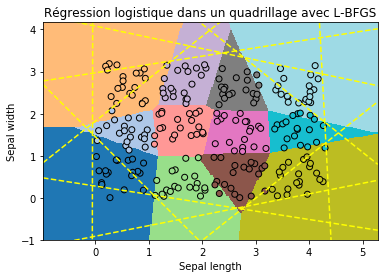

In [37]:
ax = draw_border(clr_t, X, Y, incx=1, incy=1, figsize=(6,4), border=False)
ax.set_title("Régression logistique dans un quadrillage avec L-BFGS");

Ensuite, on change la façon de résoudre le problème. Plutôt que de résoudre *n* problèmes de classifications binaires, on résoud un seul problème avec une erreur de classification égale à la [Multinomial logistic regression](https://en.wikipedia.org/wiki/Multinomial_logistic_regression).

In [38]:
clr_t = LogisticRegression(solver='lbfgs', multi_class='multinomial')
clr_t.fit(X, Y)
clr_t.score(X, Y)

0.9875

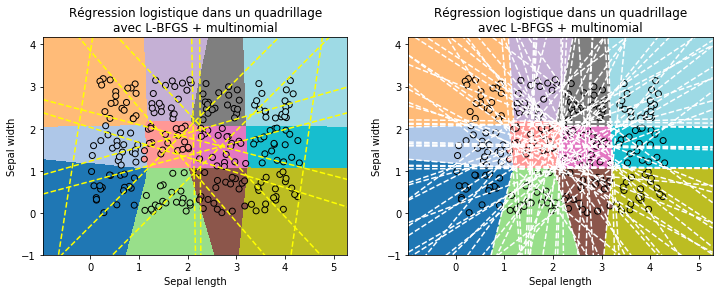

In [39]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
draw_border(clr_t, X, Y, incx=1, incy=1, figsize=(6,4), border=False, ax=ax[0])
draw_border(clr_t, X, Y, incx=1, incy=1, figsize=(6,4), border=True, ax=ax[1])
ax[0].set_title("Régression logistique dans un quadrillage\navec L-BFGS + multinomial")
ax[1].set_title("Régression logistique dans un quadrillage\navec L-BFGS + multinomial");

Les frontières entre une classes et les autres n'ont plus l'air d'avoir de signification géométrique. L'approche une classe contre toutes les autres marchent bien si celles-ci ont des frontières convexes sans angles aigus et si elles ne sont pas bornées. En gros, cette approche rapide fonctionne bien si toutes les classes sont disposées autour de la boule unité ou d'une boule unité composée sur un sous-ensemble des dimensions.

## Régression logistique autour d'un cercle

In [40]:
from math import cos, sin, pi
Xs = []
Ys = []
n = 20
for i in range(0, 12):
    x1 = numpy.random.rand(n) + 2.3*cos(i/ 12. * 2 * pi)
    x2 = numpy.random.rand(n) + 2.3*sin(i/ 12. * 2 * pi)
    Xs.append(numpy.vstack([x1,x2]).T)        
    Ys.extend([i] * n)
X = numpy.vstack(Xs)
Y = numpy.array(Ys)
X.shape, Y.shape

((240, 2), (240,))

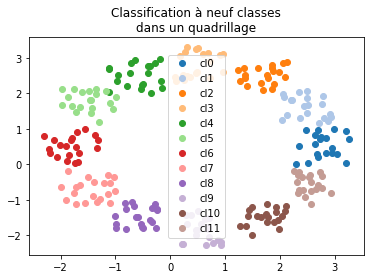

In [41]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))
for i in range(0, 12):
    ax.plot(X[Y==i,0], X[Y==i,1], 'o', label="cl%d"%i, color=plt.cm.tab20.colors[i])
ax.legend()
ax.set_title("Classification à neuf classes\ndans un quadrillage");

In [42]:
clr_c = LogisticRegression()
clr_c.fit(X, Y)
clr_c.score(X, Y)

0.9833333333333333

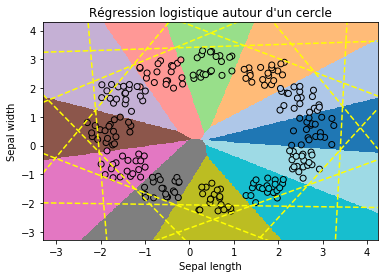

In [43]:
ax = draw_border(clr_c, X, Y, incx=1, incy=1, figsize=(6,4), border=False)
ax.set_title("Régression logistique autour d'un cercle");

Rien n'est prouvé, ce ne sont que des observations. On peut se poser la question si le problème précédent n'était pas justement choisi pour montrer que dans un cas, l'approche une classe contre les autres dans le cas d'un quadrillage est particulièrement malvenue. On accroît l'espace entre les classes.

In [44]:
Xs = []
Ys = []
n = 20
for i in range(0, 4):
    for j in range(0, 3):
        x1 = numpy.random.rand(n) + i*3
        x2 = numpy.random.rand(n) + j*3
        Xs.append(numpy.vstack([x1,x2]).T)        
        Ys.extend([i*3+j] * n)
X = numpy.vstack(Xs)
Y = numpy.array(Ys)
X.shape, Y.shape

((240, 2), (240,))

In [45]:
clr_q = LogisticRegression()
clr_q.fit(X, Y)
clr_q.score(X, Y)

0.7875

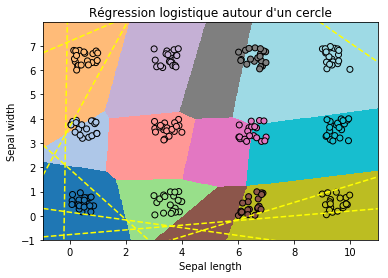

In [46]:
ax = draw_border(clr_q, X, Y, incx=1, incy=1, figsize=(6,4), border=False)
ax.set_title("Régression logistique autour d'un cercle");

A priori non mais on préfère l'approche une classe contre les autres car elle est beaucoup plus rapide. L'approche multinomiale requiert de changer d'algorithme de descente de gradient.

In [47]:
clr_q = LogisticRegression()
%timeit clr_q.fit(X, Y)

4.25 ms ± 148 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [48]:
clr_qmn = LogisticRegression(multi_class='multinomial', solver='lbfgs')
%timeit clr_qmn.fit(X, Y)

55.4 ms ± 1.18 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Pousser les classes sur la boule unité

Puisque le modèle est plus facile à apprendre lorsque les classes sont réparties sur la boule unité, l'idéal serait d'avoir une transformation qui le fait, comme d'ajouter des dimensions. La régression logistique ne peut modéliser que des classes convexes. Cela veut dire que le barycentre, sous cette hypothèses, appartient à la zone que le modèle attribute à une classe donnée. On calcule ce barycentre pour toutes les classes et on ajoute comme variables la distance à chacun de ces centres. On reprend le problème du quadrillage.

In [49]:
Xs = []
Ys = []
n = 20
for i in range(0, 4):
    for j in range(0, 3):
        x1 = numpy.random.rand(n) + i*1.1
        x2 = numpy.random.rand(n) + j*1.1
        Xs.append(numpy.vstack([x1,x2]).T)        
        Ys.extend([i*3+j] * n)
X = numpy.vstack(Xs)
Y = numpy.array(Ys)
X.shape, Y.shape

((240, 2), (240,))

In [50]:
bary = []
for i in range(12):
    b = X[Y==i].mean(axis=0)
    bary.append(b)
barys = numpy.vstack(bary)
barys.shape

(12, 2)

In [51]:
from sklearn.metrics.pairwise import euclidean_distances
dist = euclidean_distances(X, barys)
dist.shape

(240, 12)

In [52]:
Xext = numpy.hstack([X, dist])

In [53]:
clr_ext = LogisticRegression()
clr_ext.fit(Xext, Y)
clr_ext.score(Xext, Y)

0.9916666666666667

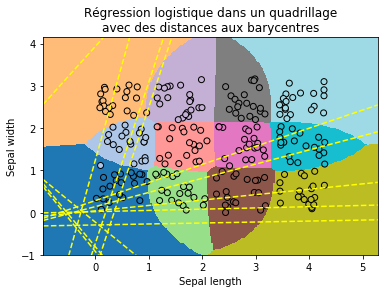

In [54]:
def fct_predict(clr, X):
    dist = euclidean_distances(X, barys)   
    Xext = numpy.hstack([X, dist])
    return clr.predict(Xext)

ax = draw_border(clr_ext, X, Y, fct=fct_predict, incx=1, incy=1, figsize=(6,4), border=False)
ax.set_title("Régression logistique dans un quadrillage\navec des distances aux barycentres");

Cela répond également à une question : **Que faire lorsque les classes ne sont pas convexes ?** Une idée consiste à effectuer un [k-means](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) par classe jusqu'à ce que chaque classe soit à peu près converte par un ensemble de cluster appris sur cette classe.

## Cas presque hexagonal

Pour tester quelques idées et parce c'est joli. L'idéal serait de se rapprocher d'un pavage de [Penrose](https://fr.wikipedia.org/wiki/Roger_Penrose).

In [55]:
import math
n = 4
a = math.pi * 2 / 3
points = []
Ys = []
for i in range(n):
    for j in range(n):
        dil = ((i+1)**2 + (j+1)**2) ** 0.6
        for k in range(0,20):
            x = i + j * math.cos(a)
            y = j * math.sin(a)
            points.append([x * dil, y * dil])
            Ys.append(i*n+j)
            mi = 0.5
            for r in [0.1, 0.3, mi]:
                nb = 6 if r == mi else 12
                for k in range(0, nb):
                    x = i + j * math.cos(a) + r * math.cos(math.pi*2/nb * k + math.pi/6)
                    y = j * math.sin(a) + r * math.sin(math.pi*2/nb * k + math.pi/6)
                    points.append([x * dil, y * dil])
                    Ys.append(i*n+j)
X = numpy.array(points)
Y = numpy.array(Ys)
set(Y)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15}

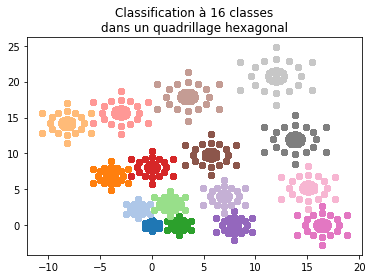

In [56]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))
for i in range(0, max(Y)+1):
    ax.plot(X[Y==i,0], X[Y==i,1], 'o', label="cl%d"%i, color=plt.cm.tab20.colors[i%20])
ax.set_title("Classification à 16 classes\ndans un quadrillage hexagonal");

In [57]:
clr_hex = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=200)
clr_hex.fit(X, Y)
clr_hex.score(X, Y)

0.9919354838709677

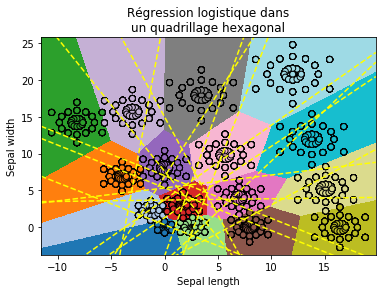

In [58]:
ax = draw_border(clr_hex, X, Y, incx=1, incy=1, figsize=(6,4), border=False)
ax.set_title("Régression logistique dans\nun quadrillage hexagonal");

## Diagramme de Voronoï approché

On pousse l'idée implémentée dans le cas de trois classes pour un nombre de classes quelconque. Il n'existe pas de façon générique de diagramme de Voronoï équivalent. On résoud le système linéaire avec une régression quantile et d'autres astuces de calculs à découvrir dans le code de la fonction [voronoi_estimation_from_lr](http://www.xavierdupre.fr/app/mlstatpy/helpsphinx//mlstatpy/ml/voronoi.html).

In [59]:
Xs = []
Ys = []
n = 20
for i in range(0, 4):
    for j in range(0, 3):
        x1 = numpy.random.rand(n) + i*1.1
        x2 = numpy.random.rand(n) + j*1.1
        Xs.append(numpy.vstack([x1,x2]).T)        
        Ys.extend([i*3+j] * n)
X = numpy.vstack(Xs)
Y = numpy.array(Ys)
X.shape, Y.shape

((240, 2), (240,))

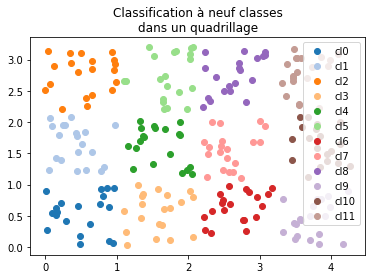

In [60]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))
for i in range(0, 12):
    ax.plot(X[Y==i,0], X[Y==i,1], 'o', label="cl%d"%i, color=plt.cm.tab20.colors[i])
ax.legend()
ax.set_title("Classification à neuf classes\ndans un quadrillage");

In [61]:
from sklearn.linear_model import LogisticRegression
clr = LogisticRegression()
clr.fit(X, Y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [62]:
from mlstatpy.ml import voronoi_estimation_from_lr
points = voronoi_estimation_from_lr(clr.coef_, clr.intercept_, max_iter=20, verbose=True)
points

[voronoi_estimation_from_lr] iter=1/20 score=0.0953 tol=3.48e-10 del P2,9 d=3.19
[voronoi_estimation_from_lr] iter=2/20 score=0.0939 tol=3.48e-10 del P1,9 d=2.72
[voronoi_estimation_from_lr] iter=3/20 score=0.089 tol=3.48e-10 del P2,6 d=2.5
[voronoi_estimation_from_lr] iter=4/20 score=0.0892 tol=3.48e-10 del P0,11 d=2.46
[voronoi_estimation_from_lr] iter=5/20 score=0.0894 tol=3.48e-10 del P2,10 d=2.42
[voronoi_estimation_from_lr] iter=6/20 score=0.0882 tol=3.48e-10 del P1,10 d=2.44
[voronoi_estimation_from_lr] iter=7/20 score=0.0889 tol=3.48e-10 del P0,10 d=2.3
[voronoi_estimation_from_lr] iter=8/20 score=0.0877 tol=3.48e-10 del P5,9 d=2.29
[voronoi_estimation_from_lr] iter=9/20 score=0.0869 tol=3.48e-10 del P1,11 d=2.18
[voronoi_estimation_from_lr] iter=10/20 score=0.088 tol=3.48e-10 del P2,3 d=2.2
[voronoi_estimation_from_lr] iter=11/20 score=0.089 tol=3.48e-10 del P0,8 d=2.14
[voronoi_estimation_from_lr] iter=12/20 score=0.0884 tol=3.48e-10 del P1,6 d=2.2
[voronoi_estimation_from_lr

array([[0.59042773, 0.41675379],
       [0.19276405, 1.61586254],
       [0.38750542, 2.34848342],
       [1.70510075, 0.5341869 ],
       [1.69940467, 1.50388896],
       [1.66571087, 2.15827251],
       [2.23834543, 0.6114512 ],
       [2.14600591, 1.3636044 ],
       [2.08762755, 2.04091816],
       [2.5732091 , 0.170076  ],
       [2.81087731, 1.40217985],
       [2.49984364, 2.02978587]])

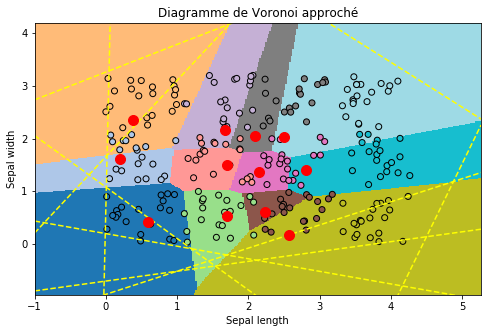

In [63]:
ax = draw_border(clr, X, Y, incx=1, incy=1, figsize=(8,5), border=False)
ax.plot(points[:, 0], points[:, 1], 'ro', ms=10)
ax.set_title("Diagramme de Voronoi approché");